## 导入基础库

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [2]:
# 在导入基础库部分后添加这段代码
import matplotlib.pyplot as plt
import matplotlib as mpl

# 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = 'stix'  # 保证数学文本也使用相似的字体

## stacking

In [3]:
data = pd.read_csv('/Users/lixian/workplace/dl_predictionv1/data/lucky_cat.csv')
y = data['risk']
X = data.drop('risk',axis=1)
print("X.shape", X.shape, "y.shape", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)


X.shape (39136, 37) y.shape (39136,)
X_train.shape (31308, 37) y_train.shape (31308,)
X_test.shape (7828, 37) y_test.shape (7828,)


In [4]:
import pickle
import torch
import torch.nn as nn

# Define the MLP class first
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 加载随机森林模型
with open('/Users/lixian/workplace/dl_predictionv1/model/model_rfc_best.pkl', 'rb') as f:
    model_rfc_best = pickle.load(f)
# 加载 LightGBM 模型
with open('/Users/lixian/workplace/dl_predictionv1/model/model_lgb_best.pkl', 'rb') as f:
    model_lgb_best = pickle.load(f)
    
# 加载 MLP 模型
model_mlp_best_real = torch.load('/Users/lixian/workplace/dl_predictionv1/model/model_mlp_best_real.pkl')

/var/folders/6_/bl3k57hx2nv_hyp55sxq7v_80000gn/T/ipykernel_4894/1274028811.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mlp_best_real = torch.load('/Users/lixi

In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import joblib  
class MLP(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim): #输入维度 input_dim 是特征数，隐藏层维度 hidden_dim 是 64，输出维度 output_dim 是 2（二分类任务）
        super(MLP, self).__init__() 
        self.fc1 = nn.Linear(input_dim, hidden_dim) #一个输入层到隐藏层的全连接层c1
        self.relu = nn.ReLU() #ReLU 激活函数
        self.fc2 = nn.Linear(hidden_dim, output_dim) #一个隐藏层到输出层的全连接层（fc2）
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize model
model = MLP(input_dim=X.shape[1], hidden_dim=64, output_dim=2)

# 加载保存的模型参数
model_path = '/Users/lixian/workplace/dl_predictionv1/model/model_mlp_best.pkl'
# 仅加载模型的权重
model.load_state_dict(torch.load(model_path, weights_only=True), strict=True)
# 加载预训练的scaler
scaler = joblib.load('/Users/lixian/workplace/dl_predictionv1/model/scaler.pkl')  
# 设置模型为评估模式
model.eval()



def mlp_predict(X_train, y_train, X_test, y_test=None):  
    # 标准化数值特征
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)
    # 将输入数据转化为张量
    X_val_tensor = torch.tensor(np.asarray(X_val), dtype=torch.float32)
    y_val_tensor = torch.tensor(np.asarray(y_val), dtype=torch.float32)
    X_test_tensor = torch.tensor(np.asarray(X_test), dtype=torch.float32)
    
    # 通过 MLP 模型进行验证集预测
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_probabilities = torch.softmax(val_outputs, dim=1)[:, 1].numpy()  # 获取正类的概率
        val_labels = y_val_tensor.numpy()
    
    # 计算验证集 AUC
    auc = roc_auc_score(val_labels, val_probabilities)
    print(f'调参后MLP单模型在验证集AUC: {auc:.4f}')
    
    # 通过 MLP 模型进行测试集预测
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_probabilities = torch.softmax(test_outputs, dim=1)[:, 1].numpy()  # 获取正类的概率
        test_pred = (test_probabilities >= 0.5).astype(int)  # 将概率转换为标签
    
    return test_pred


# 定义预测函数用于shap分析
def predict_proba_mlp(X):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    X_scaled = scaler.transform(X)  # 使用预训练的scaler
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        output = model(X_tensor)
    # 假设模型输出是 sigmoid 后的概率
        probabilities = torch.softmax(output, dim=1)
    return probabilities.numpy()


In [6]:
import lightgbm as lgb


def lgb_predict(X_train, y_train, X_test, y_test=None): 
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)
    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)
    model = lgb.train(model_lgb_best.params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix])
    """计算在验证集上的得分"""
    val_pred = model.predict(X_val)
    fpr, tpr, threshold = metrics.roc_curve(y_val, val_pred)
    roc_auc = metrics.auc(fpr, tpr)
    print('调参后lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))
    
    """对测试集进行预测"""
    test_pred = model.predict(X_test)   
     
    return test_pred


In [7]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import metrics
def rfc_predict(X_train, y_train, X_test, y_test=None):
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)
    model = RFC(** model_rfc_best.get_params())
    model = RFC().fit(X_train_split,y_train_split)   
    """计算在验证集上的得分"""
    val_pred = model.predict(X_val)
    fpr, tpr, threshold = metrics.roc_curve(y_val, val_pred)
    roc_auc = metrics.auc(fpr, tpr)
    print('调参后RandomForest单模型在验证集上的AUC：{}'.format(roc_auc))
    
    """对测试集进行预测"""
    test_pred = model.predict(X_test) 
    return test_pred


In [8]:
from heamy.dataset import Dataset
from heamy.estimator import Classifier

model_dataset = Dataset(X_train=X_train, y_train=y_train, X_test=X_test) #创建一个数据集对象 model_dataset
#使用 heamy 中的 Classifier 类来包装 XGBoost 和 LightGBM 模型，指定数据集、模型和其他相关参数,必须有回调
model_lgb = Classifier(dataset=model_dataset, estimator=lgb_predict, name='lgb', use_cache=False) #禁用了缓存功能（即每次都会重新训练模型）
model_rfc = Classifier(dataset=model_dataset, estimator=rfc_predict, name='rfc', use_cache=False) 
model_mlp = Classifier(dataset=model_dataset, estimator=mlp_predict, name='mlp', use_cache=False)


In [9]:
from heamy.pipeline import ModelsPipeline

pipeline = ModelsPipeline(model_mlp, model_lgb, model_rfc)
pipeline


In [10]:
# 构建第一层新特征，其中k默认是5，表示5折交叉验证，full_test=True，对全部训练集进行训练得到基学习器，然后用基学习器对测试集预测得到新特征
stack_ds = pipeline.stack(k=5, seed=111, full_test=True)


调参后MLP单模型在验证集AUC: 0.9777
调参后MLP单模型在验证集AUC: 0.9784
调参后MLP单模型在验证集AUC: 0.9773
调参后MLP单模型在验证集AUC: 0.9751
调参后MLP单模型在验证集AUC: 0.9738
调参后MLP单模型在验证集AUC: 0.9785


/Users/lixian/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


调参后lightgbm单模型在验证集上的AUC：0.9676614461527429


/Users/lixian/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


调参后lightgbm单模型在验证集上的AUC：0.9674178953368833


/Users/lixian/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


调参后lightgbm单模型在验证集上的AUC：0.9675843286855231


/Users/lixian/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


调参后lightgbm单模型在验证集上的AUC：0.9666009730684936


/Users/lixian/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


调参后lightgbm单模型在验证集上的AUC：0.9677788383245882


/Users/lixian/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


调参后lightgbm单模型在验证集上的AUC：0.9698198436677716
调参后RandomForest单模型在验证集上的AUC：0.9373207647900174
调参后RandomForest单模型在验证集上的AUC：0.9382020009851778
调参后RandomForest单模型在验证集上的AUC：0.9352685857158886
调参后RandomForest单模型在验证集上的AUC：0.9353640018206785
调参后RandomForest单模型在验证集上的AUC：0.9400866135068685
调参后RandomForest单模型在验证集上的AUC：0.9390327872916079


In [15]:
from sklearn.linear_model import LogisticRegression
# 第二层使用逻辑回归进行stack
LogisticRegression(solver='lbfgs')
stacker = Classifier(dataset=stack_ds, estimator=LogisticRegression, parameters={'solver': 'lbfgs'})

# 测试集的预测结果
test_pred = stacker.predict()
print(test_pred)
print(type(test_pred))
# 计算测试集 AUC
auc = roc_auc_score(y_test, test_pred)
print(f'多模型在测试集AUC: {auc:.4f}')
    

[0.99747316 0.99727616 0.2946924  ... 0.05384245 0.09695909 0.02982887]
<class 'numpy.ndarray'>
多模型在测试集AUC: 0.9812


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_pred_labels = (test_pred >= 0.5).astype(int)
accuracy_test = accuracy_score(y_test, test_pred_labels)
precision_test = precision_score(y_test, test_pred_labels)
recall_test = recall_score(y_test, test_pred_labels)
f1_test = f1_score(y_test, test_pred_labels)

print(f"测试集准确率: {accuracy_test:.4f}")
print(f"测试集精确率: {precision_test:.4f}")
print(f"测试集召回率: {recall_test:.4f}")
print(f"测试集F1分数: {f1_test:.4f}")

测试集准确率: 0.9443
测试集精确率: 0.9817
测试集召回率: 0.9069
测试集F1分数: 0.9428


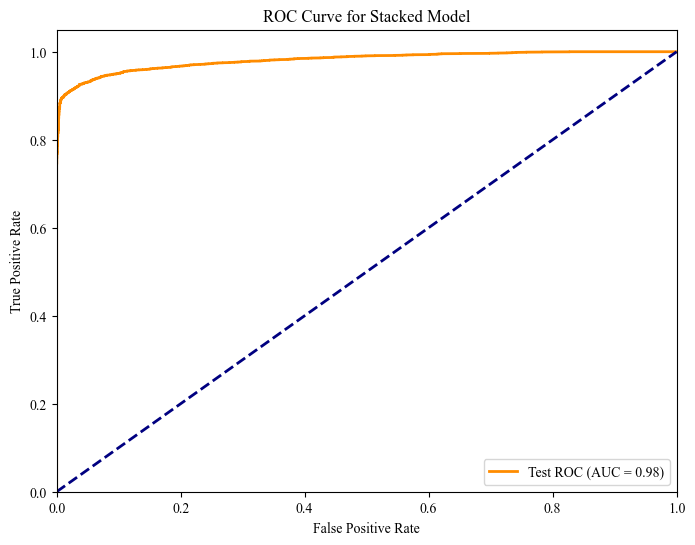

In [13]:
# 绘制测试集的 ROC 曲线
from sklearn.metrics import roc_curve
test_fpr, test_tpr, _ = roc_curve(y_test, test_pred)
test_auc = roc_auc_score(y_test, test_pred)

plt.figure(figsize=(8, 6))
plt.plot(test_fpr, test_tpr, color='darkorange', lw=2, label=f'Test ROC (AUC = {test_auc:.2f})')  # 橙色代表测试集
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 随机猜测的对角线

# 调整图像显示范围
plt.xlim([0.0, 1.0])  # 设置x轴范围
plt.ylim([0.0, 1.05])  # 设置y轴范围

# 设置图表标签
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stacked Model')  

# 添加图例
plt.legend(loc="lower right")

# 显示图像
plt.show()

## shap分析

In [13]:
# import numpy as np
# import shap

# # 假设 X_train 和 model_lgb_best 已经定义
# # 使用 X_train 的一部分作为背景数据（这里选择前100个样本）
# background = X_train[:100]

# # 初始化 SHAP TreeExplainer
# explainer = shap.TreeExplainer(model_lgb_best,
#                                data=background,
#                                model_output="probability",
#                                feature_perturbation="interventional")

# # 计算 SHAP 值
# shap_vals = explainer.shap_values(X_train)
# print("原始 SHAP 值 shape:", shap_vals.shape)

# # 如果返回的 shape 的第一个维度等于 X_train 的样本数，则不需要转置，否则转置
# if shap_vals.shape[0] == X_train.shape[0]:
#     shap_vals_correct = shap_vals  # 已经是 (n_samples, n_features)
# else:
#     shap_vals_correct = shap_vals.T  # 转置为 (n_samples, n_features)
# print("调整后的 SHAP 值 shape:", shap_vals_correct.shape)

# # 根据二分类的加性性质，负类的 SHAP 值可以取正类 SHAP 值的相反数
# shap_vals_neg = -shap_vals_correct

# # 堆叠得到 (n_samples, n_features, 2)，其中最后一维：[负类, 正类]
# shap_values_stacked = np.stack([shap_vals_neg, shap_vals_correct], axis=-1)
# print("堆叠后的 SHAP 值 shape:", shap_values_stacked.shape)


In [14]:
import shap
import pickle
from sklearn.linear_model import LogisticRegression

# 1. 获取元模型系数
stacked_X_train = stack_ds.X_train
stacked_y_train = stack_ds.y_train
meta_model = LogisticRegression(solver='lbfgs')
meta_model.fit(stacked_X_train, stacked_y_train)
coefficients = meta_model.coef_[0]
print("逻辑回归系数:", coefficients)

# 2. 计算基模型 SHAP 值

# 使用K-means生成代表性背景样本（100个）
X_sample = shap.kmeans(X_train, 100)  
explainer = shap.DeepExplainer(model_mlp_best_real, torch.tensor(scaler.transform(X_sample.data), dtype=torch.float32))
shap_values_mlp = explainer.shap_values(torch.tensor(scaler.transform(X_train), dtype=torch.float32))


shap_values_lgb_nc = shap.TreeExplainer(model_lgb_best,data=X_train[:100], model_output="probability",feature_perturbation="interventional").shap_values(X_train)

shap_values_lgb = np.stack([-shap_values_lgb_nc, shap_values_lgb_nc], axis=-1)

shap_values_rfc = shap.TreeExplainer(model_rfc_best).shap_values(X_train)


print("SHAP values shapes:")
print("MLP:", shap_values_mlp.shape)
print("LGB:", shap_values_lgb.shape)
print("RFC:", shap_values_rfc.shape)

# 3. 合并 SHAP 值
shap_values_final = (coefficients[0] * shap_values_mlp + 
                     coefficients[1] * shap_values_lgb + 
                     coefficients[2] * shap_values_rfc)




逻辑回归系数: [2.03752571 6.3337726  2.48158303]


/Users/lixian/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
100%|===================| 31208/31308 [03:36<00:00]        

SHAP values shapes:
MLP: (31308, 37, 2)
LGB: (31308, 37, 2)
RFC: (31308, 37, 2)


In [14]:
print(shap_values_final.shape)

(31308, 37, 2)


### 蜂群图

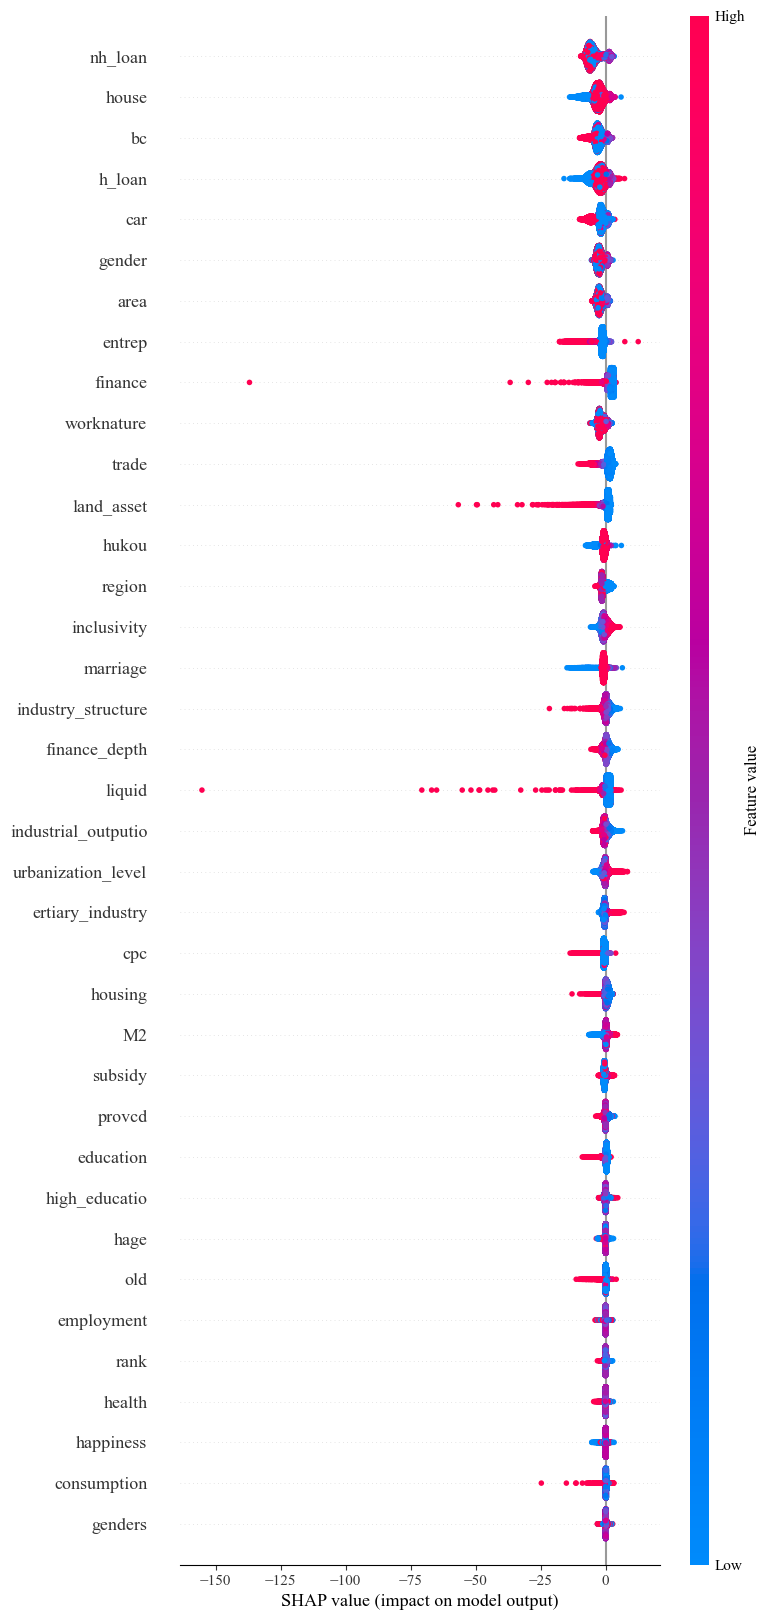

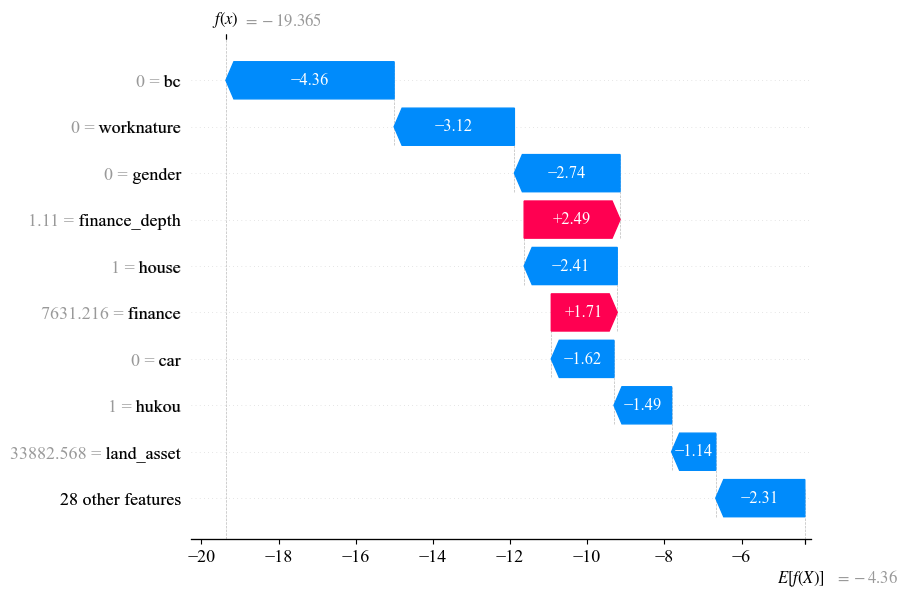

In [17]:
# 假设 shap_values_final 的形状为 (31308, 37, 2)
# 选择正类（第二个类别）的 SHAP 值，得到 (31308, 37)
shap_values_pos = shap_values_final[:, :, 1]

# 1. 绘制 summary plot
shap.summary_plot(shap_values_pos, X_train, feature_names=X_train.columns,max_display = 37)

# 2. 绘制单个样本的 SHAP 瀑布图
# 对于单个样本（例如第一行），选择正类的 SHAP 值，其形状为 (37,)
# 同时 expected_value 应该为正类的基准输出值
expected_value = (coefficients[0] * shap_values_mlp[:, :, 1] + 
                  coefficients[1] * shap_values_lgb[:, :, 1] + 
                  coefficients[2] * shap_values_rfc[:, :, 1])

shap.waterfall_plot(shap.Explanation(values=shap_values_final[1, :, 1],
                                     base_values=expected_value[1, 1],
                                     data=X_train.iloc[1],
                                     feature_names=X_train.columns.tolist()))

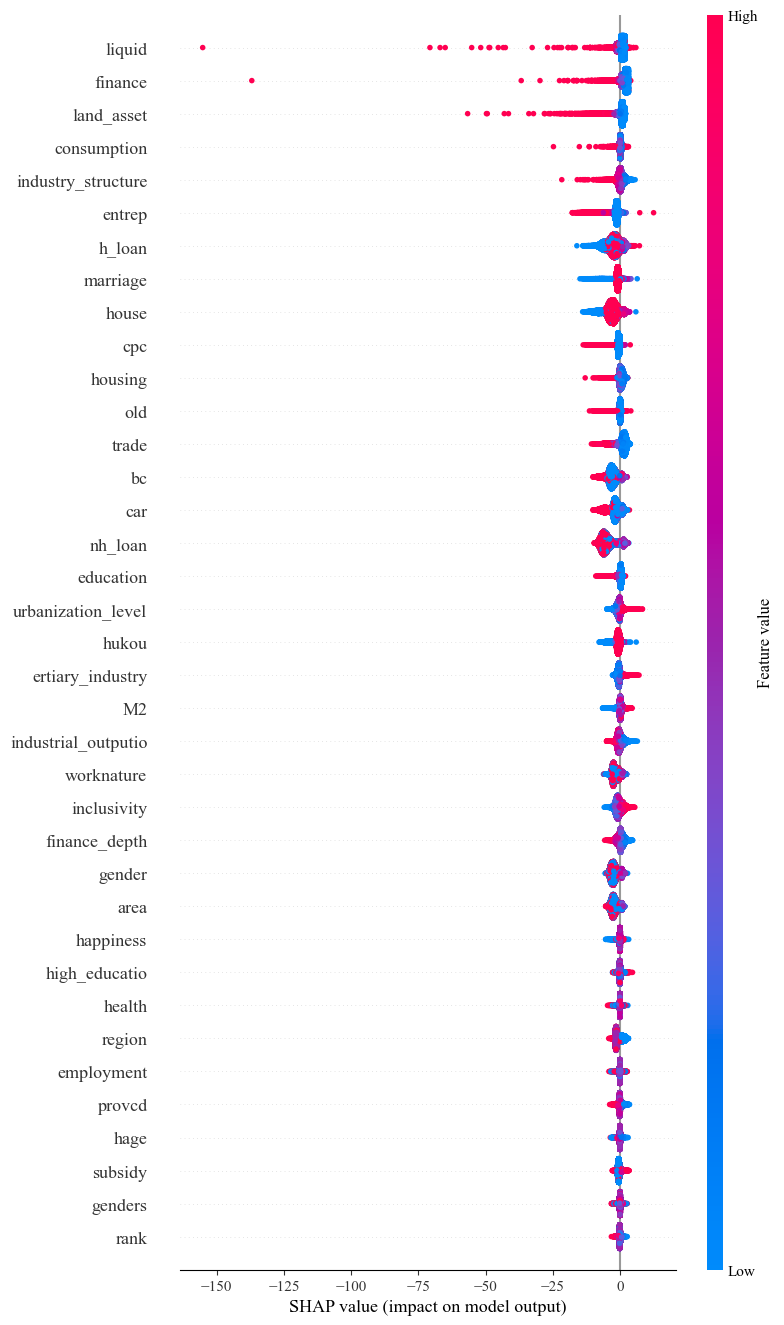

In [18]:
# 在调用 SHAP 可视化函数前设置 matplotlib 参数
import matplotlib as mpl

# 设置全局字体为 Times New Roman
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['mathtext.fontset'] = 'stix'

#  shap_values_pos 从NumPy 数组转换为 shap.Explanation 对象
shap_values_pos_shap = shap.Explanation(values=shap_values_pos, data=X_train, feature_names=X_train.columns)

# 1. 使用 beeswarm 绘制图表
shap.plots.beeswarm(shap_values_pos_shap, max_display=37, order=shap_values_pos_shap.abs.max(0))

### 依赖图

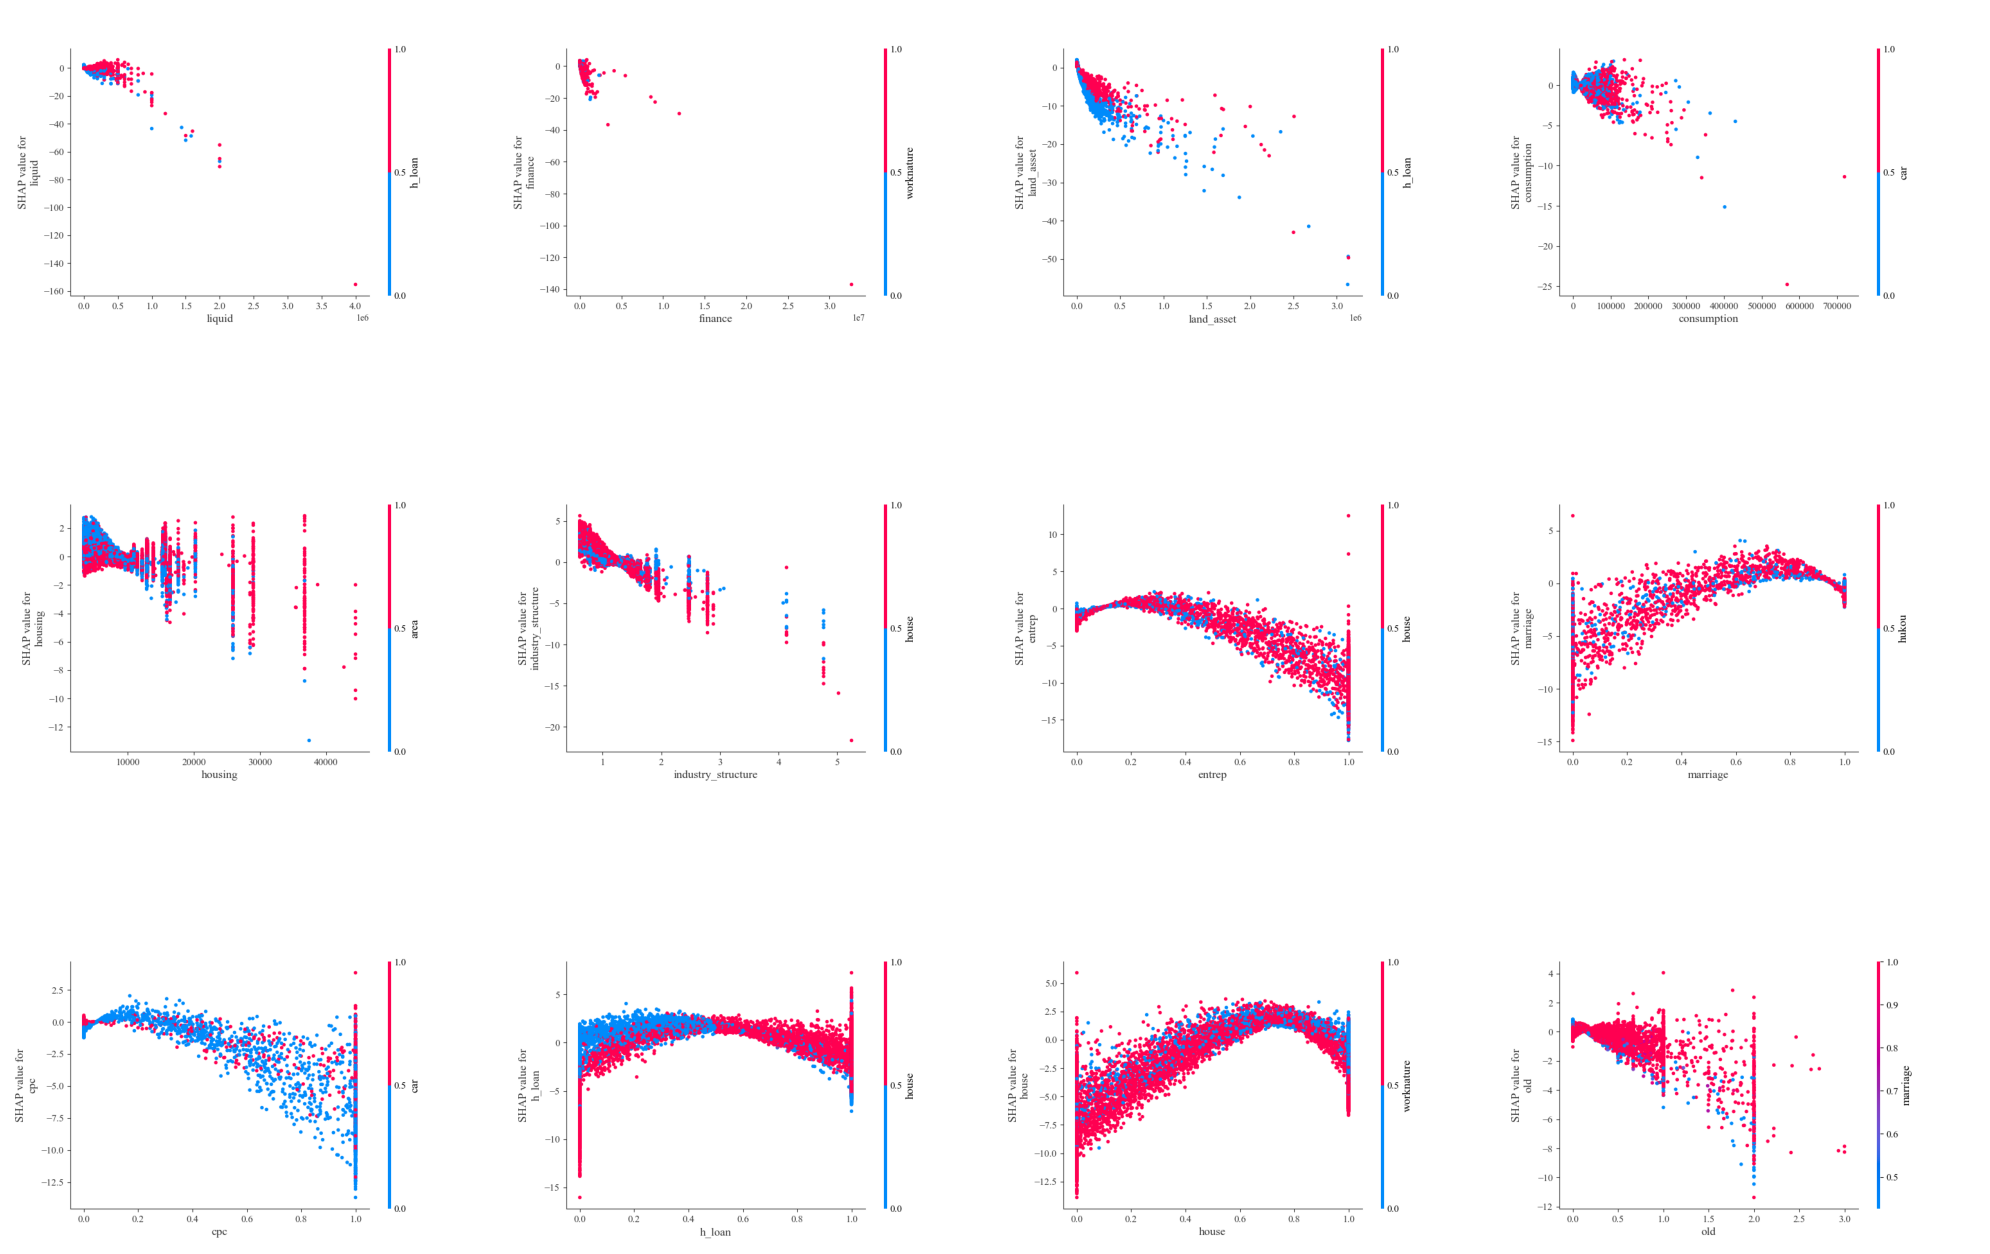

In [19]:
import shap
import matplotlib.pyplot as plt
import io
from PIL import Image

# 选择前12个特征
selected_features = ['liquid', 'finance', 'land_asset', 'consumption', 'housing', 
                     'industry_structure', 'entrep', 'marriage', 'cpc', 'h_loan', 'house', 'old']

# 创建3行4列的子图
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    # 使用内存缓冲区保存依赖图
    buf = io.BytesIO()
    # 设置 show=False 防止立即显示
    shap.dependence_plot(feature, shap_values_pos, X_train, feature_names=X_train.columns, show=False)
    plt.savefig(buf, format='png')
    plt.close()  # 关闭依赖图生成的图形窗口
    buf.seek(0)
    im = Image.open(buf)
    
    # 将图片显示在对应的子图上
    axes[i].imshow(im)
    axes[i].axis('off')  # 关闭坐标轴

plt.tight_layout()
plt.show()

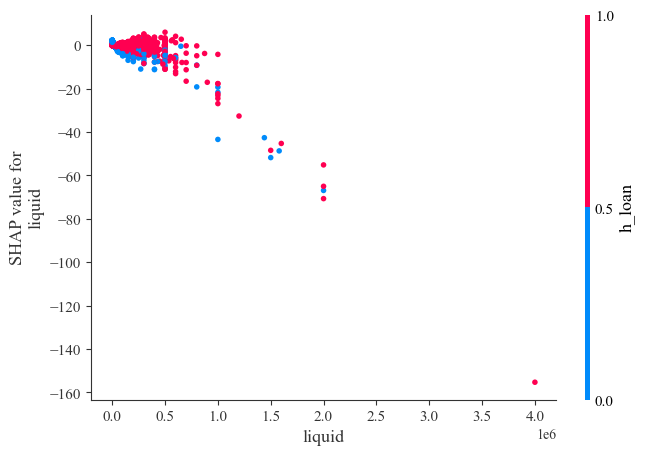

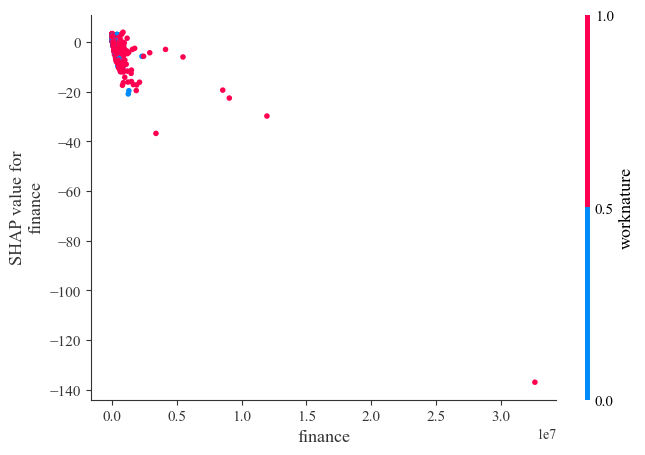

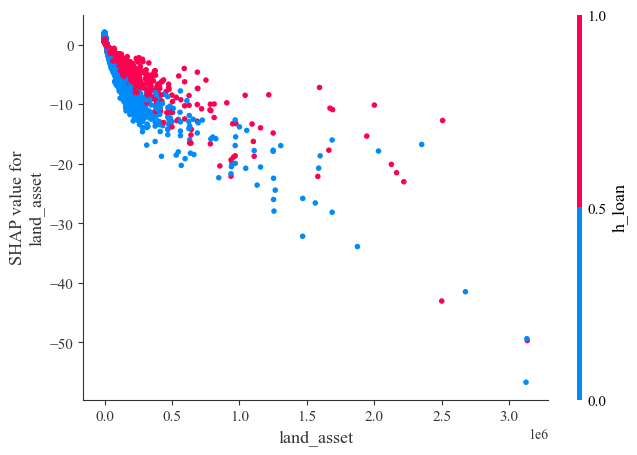

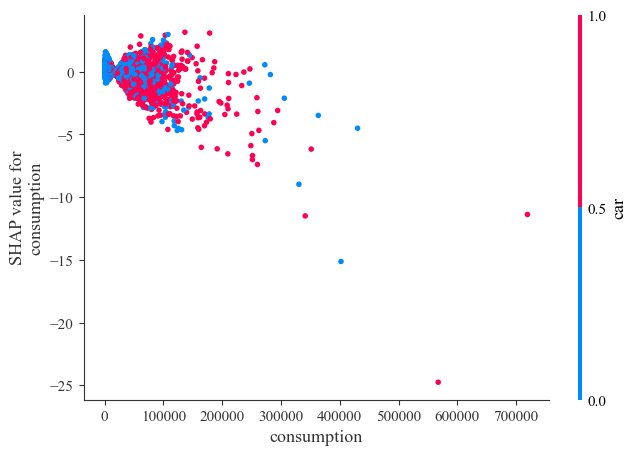

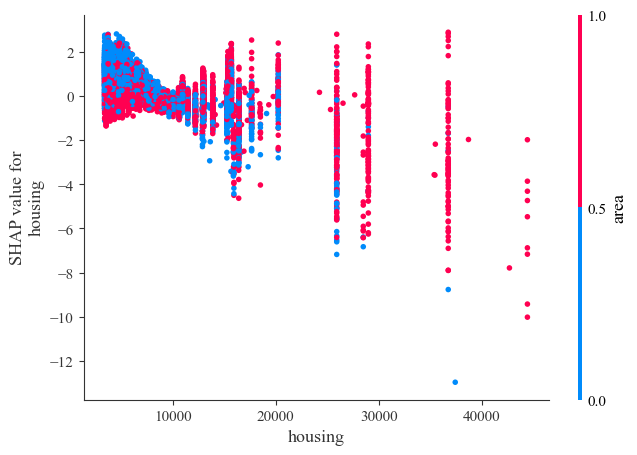

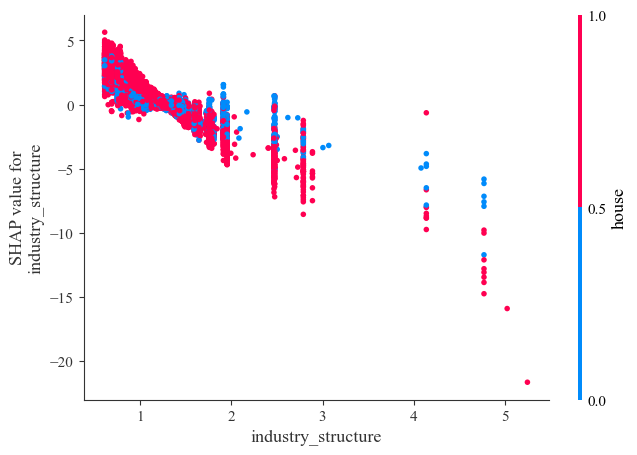

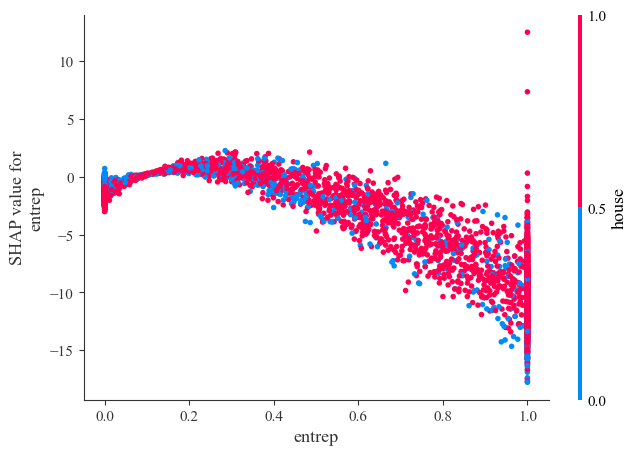

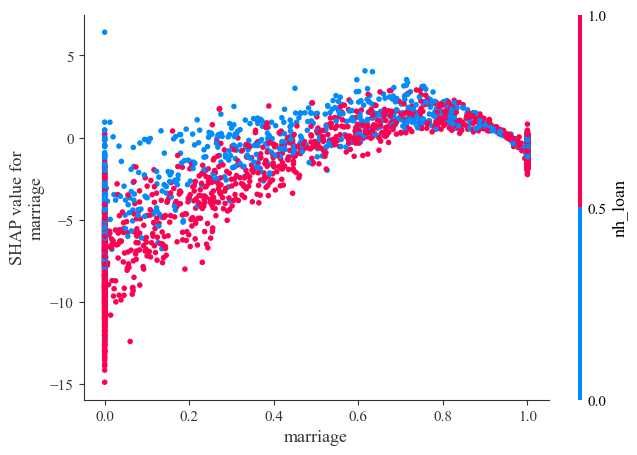

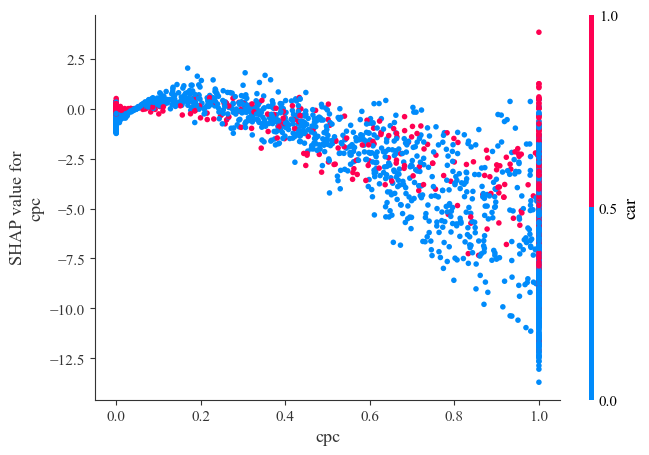

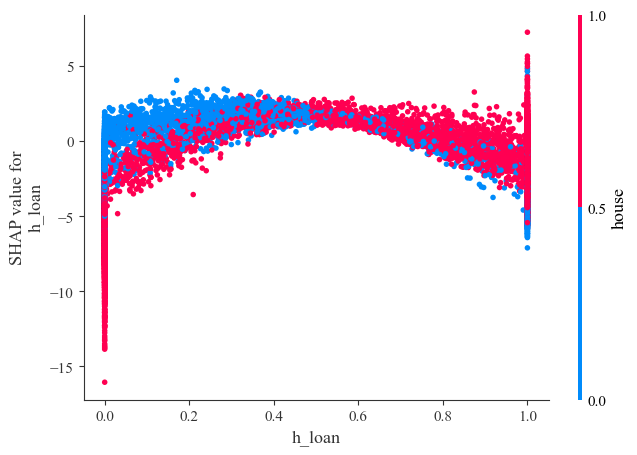

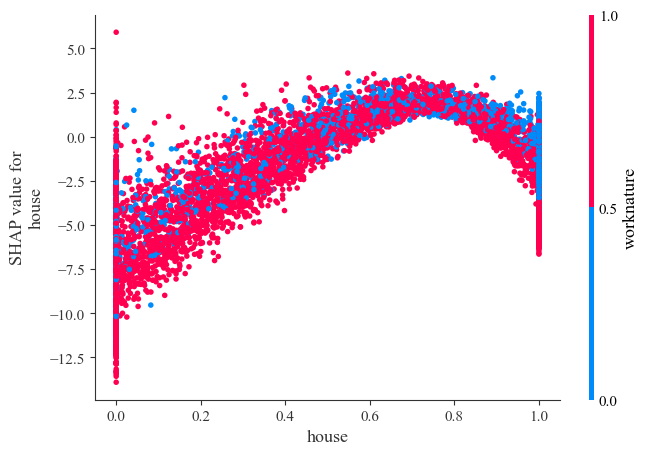

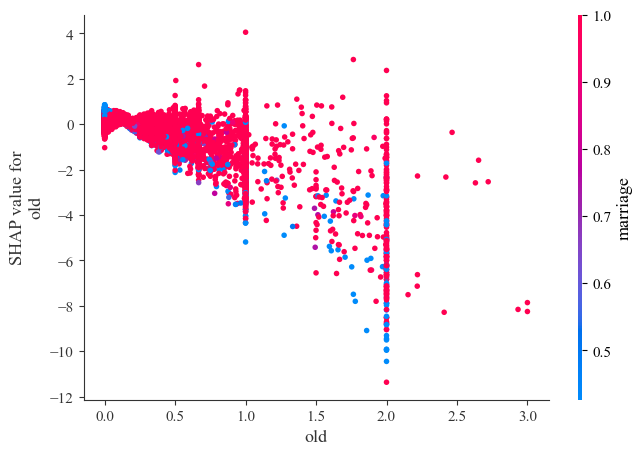

In [20]:

# 选择前12个特征
selected_features = ['liquid', 'finance', 'land_asset', 'consumption', 'housing', 'industry_structure', 'entrep', 'marriage', 'cpc', 'h_loan','house','old']

# 为每个特征绘制依赖图
for feature in selected_features:
    shap.dependence_plot(feature, shap_values_pos, X_train, feature_names=X_train.columns) 

### 散点图

In [19]:
import shap

# 选择前12个特征
selected_features = ['liquid', 'finance', 'land_asset', 'consumption', 'housing', 'industry_structure', 'entrep', 'marriage', 'cpc', 'h_loan','house','old']
# 为每个特征绘制散点图
for feature in selected_features:
    shap.plots.scatter(feature, shap_values_pos_shap, X_train)

AssertionError: The shap_values parameter must be a shap.Explanation object!

## 使用blending融合

In [21]:
from sklearn.linear_model import LogisticRegression
# 构建第一层新特征，将训练集切分成8:2，其中80%用于训练基学习器，20%用于构建新特征
blend_ds = pipeline.blend(proportion=0.2,seed=111)
# 第二层使用逻辑回归进行blend
blender = Classifier(dataset=blend_ds, estimator=LogisticRegression, parameters={'solver': 'lbfgs'})
# 测试集的预测结果
test_pred = blender.predict()
test_pred
# 计算测试集 AUC
auc = roc_auc_score(y_test, test_pred)
print(f'多模型在测试集AUC: {auc:.4f}')

调参后MLP单模型在验证集AUC: 0.9728


/Users/lixian/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


调参后lightgbm单模型在验证集上的AUC：0.9666734198538284
调参后RandomForest单模型在验证集上的AUC：0.9396241954953638
多模型在测试集AUC: 0.9765


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_pred_labels = (test_pred >= 0.5).astype(int)
accuracy_test = accuracy_score(y_test, test_pred_labels)
precision_test = precision_score(y_test, test_pred_labels)
recall_test = recall_score(y_test, test_pred_labels)
f1_test = f1_score(y_test, test_pred_labels)

print(f"测试集准确率: {accuracy_test:.4f}")
print(f"测试集精确率: {precision_test:.4f}")
print(f"测试集召回率: {recall_test:.4f}")
print(f"测试集F1分数: {f1_test:.4f}")

测试集准确率: 0.9398
测试集精确率: 0.9797
测试集召回率: 0.8998
测试集F1分数: 0.9381


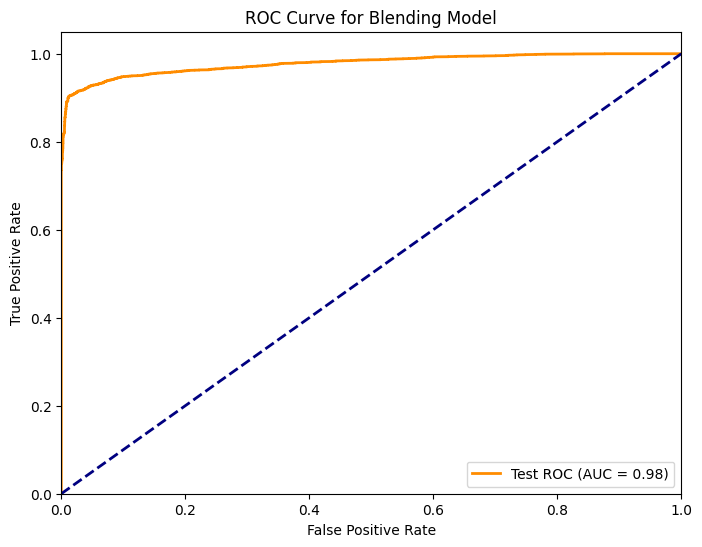

In [86]:
# 绘制测试集的 ROC 曲线
from sklearn.metrics import roc_curve
test_fpr, test_tpr, _ = roc_curve(y_test, test_pred)
test_auc = roc_auc_score(y_test, test_pred)

plt.figure(figsize=(8, 6))
plt.plot(test_fpr, test_tpr, color='darkorange', lw=2, label=f'Test ROC (AUC = {test_auc:.2f})')  # 橙色代表测试集
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 随机猜测的对角线

# 调整图像显示范围
plt.xlim([0.0, 1.0])  # 设置x轴范围
plt.ylim([0.0, 1.05])  # 设置y轴范围

# 设置图表标签
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Blending Model')  

# 添加图例
plt.legend(loc="lower right")

# 显示图像
plt.show()